## Content Based Movie Recommender System

#### Life Cycle of Capstone Project

- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Exploratory data analysis
- Data Pre-Processing
- Model Training
- Choose best model

### 1) Problem statement
- This capstone project aims to design an improved content-based movie recommendation system that
integrates diverse feature types effectively while ensuring computational efficiency

### 2) Data Collection
- Data source - https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews/data
- The data consists of two .csv file
   >movie dataset (14 Mn rows, 16 column)
   
   >Review dataset (140 K rows, 11 column)

### **2.1 Import data and Required Packages**


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
import seaborn as sns
from nltk.corpus import stopwords

#### Import the csv data as DataFrame

In [ ]:
movie = pd.read_csv('Data\movie.csv')

In [54]:
review = pd.read_csv('Data\credits.csv')

In [ ]:
review.head()

#### Show top five records

In [ ]:
movie.head(5)
review.head(5)

#### Shape of the dataset

In [18]:
movie.shape

(143258, 16)

In [17]:
review.shape

(1444963, 11)

### **2.2 Data Information**

> Movie Dataset
- **id** : Unique Identifier
- **title**: title of the movie
- **audienceScore** : Average score of regular viewers
- **tomatoMeter**: Percentage of positive reviews from professional critics
- **rating**: Age based classification
- **ratingContents**: content leading to the rating classification
- **releaseDateTheaters**: Release date
- **releaseDateStreaming**: Streaming date
- **runtimeMinutes**: Duration of movie in minutes
- **genre**: Movie genre
- **originalLanguage**: Original Language of the movie
- **director**: Movie Director
- **writer**: Movie writer
- **boxOffice**: Box office revenue
- **distributor**: Distribution Company
- **soundMix**: Audio format

> Review Dataset
- **id** : Unique Identifier (Matches with Movie Dataset)
- **reviewId**: unique identifier for each critic review
- **creationDate** : Date the review was created
- **criticName**: Name of the critic
- **isTopCritic**: Boolean value indicating if the critic is top critic
- **originalScore**: critic score
- **reviewState**: Status of the review
- **publicatioName**: Name of the publication
- **reviewText**: Full text of the critic review 
- **scoreSentiment**: Sentiment of the critic score
- **reviewUrl**: The URL of the original review on Rotten Tomatoes



### **3. Data checks to perform**
- check the missing values
- check Duplicates
- check Data type
- check the number of unique values of each column
- check statistics of data set
- check various categories present in the different categorical column

#### 3.1 check the missing values
> Movie Dataset

In [ ]:
movie.isna().sum()

In [ ]:
print('Percentage of missing values in movie dataset per column:')
print((movie.isnull().sum() / len(movie) * 100).round(2))

- Dropping null values of title and columns with missing percentage > 70%

In [3]:
movie['title'] = movie['title'].dropna()
drop_columns = ['tomatoMeter','rating','ratingContents','releaseDateTheaters','boxOffice','distributor', 'soundMix']
movie = movie.drop(columns=drop_columns)

> Review Dataset

In [12]:
review.isna().sum()

id                     0
reviewId               0
creationDate           0
isTopCritic            0
originalScore     435218
reviewText         69225
scoreSentiment         0
dtype: int64

In [120]:
print('Percentage of missing values in review dataset per column:')
print((review.isnull().sum() / len(review) * 100).round(2))

Percentage of missing values in review dataset per column:
Title                0.00
reviewId             0.00
creationDate         0.00
isTopCritic          0.00
originalScore       30.11
reviewText           4.80
scoreSentiment       0.00
cleaned_text         0.00
score               32.59
normalizedScore    100.00
dtype: float64


In [14]:
review.columns

Index(['title', 'reviewId', 'creationDate', 'isTopCritic', 'originalScore',
       'reviewText', 'scoreSentiment'],
      dtype='object')

### **3.2 Check duplicates**

In [4]:
movie['id'].duplicated().sum()
movie = movie.drop_duplicates(subset=['id'])

In [36]:
review['id'].duplicated().sum()

np.int64(1375700)

### **3.3 Check data types**

In [ ]:
movie.info()

In [ ]:
review.info()

### **3.4) Check the number of unique columns**

In [ ]:
movie[['genre','originalLanguage','director','writer']].nunique()

In [7]:
print('Number of common movie IDs:', len(set(movie['id']).intersection(set(review['id']))))

Number of common movie IDs: 69260


### **Review datset cleaning**
> Removing column from review data
- ID is replaced with title
- criticName: isTopCritic columns provides the details of critc
- reviewState,publicatioName,reviewUrl : Not necessary for recommendation

In [76]:
review = pd.read_csv('Data\credits.csv')

In [77]:
review.rename(columns={'id': 'title'},inplace=True)

#### Cleaning Review dataset
> Dropped duplicate values of reviewId

In [78]:
review = review.drop_duplicates(subset=['reviewId'], keep='first').reset_index(drop=True)

> removing the stopwords from reviewtext

In [79]:
stop_words = set(stopwords.words('english'))

def clean_review(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs and HTML tags
    text = re.sub(r'http\S+|www\S+|<.*?>', '', text)
    # Remove special characters and numbers (keep only letters)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    # Join back into string
    return ' '.join(filtered_tokens)

- New column cleaned_text after removing the stopwords

In [80]:
review['cleaned_text']= review['reviewText'].astype(str).apply(clean_review)

#### Normalizing the original score

In [81]:
import re
import numpy as np

def normalize_original_score(score):
    if not isinstance(score, str):
        return np.nan

    score = score.strip().lower().replace(" ", "")

    # --- Grade to score mapping ---
    grade_map = {
        "a+++": 10, "a++": 10, "a+": 10, "a-": 6,
        "b++": 8.5, "b": 8, "b-":5,
        "c+": 7, "c": 6.5, "c-": 4,
        "d+": 5.5, "d": 5, "d-": 3,
        "f+": 4, "f": 3, "f-": 2,
        "a--": 4, "b--": 3, "c--": 2  # Extras from your list
    }
    if score in grade_map:
        return grade_map[score]

    # --- Star keywords ---
    star_keywords = {
        "fivestars": 10,
        "fourstars": 8,
        "threestars": 6,
        "twostars": 4,
        "onestar": 2,
        "zerostars": 1,
        "stars": np.nan, "star": np.nan, "capsule": np.nan
    }
    if score in star_keywords:
        return star_keywords[score]

    # --- Sentiment-based values ---
    sentiment_map = {
        "recommended": 7,
        "highlyrecommended": 9,
        "notrecommended": 3,
        "stronglynotrecommended": 1,
        "bomb": 1,
        "awful": 1,
        "void": 1,
        "ripples": 6,
        "catchitoncable": 5,
        "matinee": 7,
        "bigscreenwatch": 7.5,
        "lowbigscreenwatch": 4,
        "highrental": 6,
        "rental": 5,
        "mixed": 5,
        "readabook": 2,
        "turkey": 2
    }
    if score in sentiment_map:
        return sentiment_map[score]

    # --- Percentages ---
    if score.endswith('%'):
        try:
            return float(score.replace('%', '')) / 10
        except:
            return np.nan
        
    # --- Half-star ratings (e.g., "2 1/2 stars", "4 1/2 stars") ---
    half_star_pattern = r'(\d+)\s*1/2\s*stars?'
    half_star_match = re.search(half_star_pattern, score)
    if half_star_match:
        stars = float(half_star_match.group(1))
        return round((stars + 0.5) * 2, 1)  # Convert to 10-point scale


    # --- Fractional forms (like 3/5, 4of5, 7.5/10 etc.) ---
    match = re.search(r'(\d+(\.\d+)?)[^0-9]+(\d+)', score)
    if match:
        try:
            numerator = float(match.group(1))
            denominator = float(match.group(3))
            if denominator != 0:
                return round((numerator / denominator) * 10, 1)
        except:
            return np.nan

    # --- Numbers out of 5 (like 2 → 4 out of 10) ---
    if re.fullmatch(r'\d(\.\d+)?', score):
        val = float(score)
        if val <= 5:
            return round(val * 2, 1)
        elif val <= 10:
            return val
        else:
            return np.nan

    return np.nan

In [82]:
review['score'] = review['originalScore'].apply(normalize_original_score)

- converting the scoresentiment and isTopCritic to binary values 

In [92]:
review['scoreSentiment'] = review['scoreSentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})
review['isTopCritic'] = review['isTopCritic'].astype(int)

In [93]:
review.rename(columns={'scoreSentiment': 'sentiment'}, inplace=True)
review.rename(columns={'isTopCritic': 'TopCritic'}, inplace=True)

In [122]:
review.dropna(subset=['score'], inplace=True)


> Removing the columns after cleaning the dataset

In [95]:
drp = ['creationDate','originalScore','reviewText','criticName','reviewState','publicatioName','reviewUrl']
review = review.drop(columns=drp)

In [96]:
review.columns

Index(['title', 'reviewId', 'TopCritic', 'sentiment', 'cleaned_text', 'score'], dtype='object')

### merging the title with multiple reviewId

> Why?
- Multiple reviews for movie by  critic and publication 

In [102]:
grouped_reviews = review.groupby('title').agg({
    'reviewId': lambda x: list(x.unique()),
    'TopCritic':  lambda x: x.mode()[0] if len(x.mode()) == 1 else 1,
    'sentiment': lambda x: x.mode()[0] if len(x.mode()) == 1 else 1,
    'cleaned_text': lambda x: ' '.join(x),
    'score': 'median'
}).reset_index()

In [ ]:
col = ['reviewId']
grouped_reviews= grouped_reviews.drop(columns=col)


In [136]:
grouped_reviews.to_csv('Data\grouped_reviews.csv', index=True)

In [ ]:
grouped_reviews= grouped_reviews[~grouped_reviews['cleaned_text'].str.contains('nan', na=False)]
grouped_reviews= grouped_reviews[~grouped_reviews['cleaned_text'].str.contains('nan nan', na=False)]

In [152]:
grouped_reviews.head()

,title,TopCritic,sentiment,cleaned_text,score
0,$5_a_day,0,1,day isnt perfect examine issues connecting par...,5.85
2,mhz,0,1,stylishly minimalist plot executed beautifully...,5.00
5,,0,1,certainly tigers film filled heart,6.20
6,day,1,1,doesnt quite manage either gritty musical conv...,5.00
8,violent-women,0,0,incredibly bad sexploitation flick,4.00


### Removing space, digits from title

In [138]:
import re

def clean_movie_id(title):
    return re.sub(r'^\d+[-_]', '', title)

grouped_reviews['title'] = grouped_reviews['title'].apply(clean_movie_id)

def remove_trailing_digits(title):
    # Removes underscore + digits or just digits at the end
    return re.sub(r'[_]?\d+$', '', title)

grouped_reviews['title'] = grouped_reviews['title'].apply(remove_trailing_digits)

def remove_trailing_year(title):
    return re.sub(r'_(19|20)\d{2}$', '', title)

grouped_reviews['title'] = grouped_reviews['title'].apply(remove_trailing_year)

In [159]:
grouped_reviews = grouped_reviews.rename(columns={'title': 'id'})


# ***cleaning movie dataset**

In [36]:
movie.head(5)

,id,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer
0,space-zombie-bingo,Space Zombie Bingo!,50.0,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta"
1,the_green_grass,The Green Grass,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards
2,love_lies,"Love, Lies",43.0,NaN,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin"
3,the_sore_losers_1997,Sore Losers,60.0,2020-10-23,90.0,"Action, Mystery & thriller",English,John Michael McCarthy,John Michael McCarthy
4,dinosaur_island_2002,Dinosaur Island,70.0,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Will Meugniot,John Loy


In [71]:
movie = pd.read_csv('Data\movie.csv')

In [81]:
movie.shape

(126403, 7)

In [78]:
movie.columns

Index(['id', 'title', 'audienceScore', 'genre', 'originalLanguage', 'director',
       'writer'],
      dtype='object')

### Dropping duplicate values 

In [79]:
movie.drop_duplicates(subset=['id'], keep='first', inplace=True)
movie.drop_duplicates(subset=['title'], keep='first', inplace=True)

### removing null values and columns having missing value > 75%

In [74]:
movie.dropna(subset=['title'], inplace=True)
drop_movie_col= ['releaseDateStreaming','runtimeMinutes','tomatoMeter','rating','ratingContents',
                 'releaseDateTheaters','boxOffice','distributor', 'soundMix']
movie = movie.drop(columns=drop_movie_col)

### Imputing unknown to null values of features

In [ ]:
movie['director'].fillna("unknown", inplace=True)
movie['writer'].fillna("unknown", inplace=True)
movie['originalLanguage'].fillna("unknown", inplace=True)
movie['genre'].fillna("unknown", inplace=True)

In [100]:
movie.to_csv('cleaned_movie.csv')

### Converting feature to list

In [88]:
import re
# 1. Turn each genre string into a clean Python list
def split(s):
    if pd.isna(s):
        return []   # or ['Unknown'] if you prefer
    # Split on comma or ampersand (&), using regex
    parts = re.split(r',|&', s)
    # Strip whitespace and drop any empty strings
    return [p.strip() for p in parts if p.strip()]

movie['genre_list'] = movie['genre'].apply(split)
movie['director_list'] = movie['director'].apply(split)
movie['writer_list'] = movie['writer'].apply(split) 
movie['language']= movie['originalLanguage'].apply(split)

In [153]:
movie = pd.read_csv('cleaned_movie.csv')

> Kept the columns in list

In [ ]:

drop_col = ['Unnamed: 0', 'genre','originalLanguage', 'director', 'writer','known_score', 'unknown_score']
movie.drop(columns=drop_col, inplace=True)

#### **Merge both movie and review with id**

In [160]:
merged_df = pd.merge(movie, grouped_reviews, on='id', how='inner')

In [165]:
merged_df.to_csv('data\merged_movie_reviews.csv', index=True)

In [166]:
merged_df = merged_df.drop(columns=['id'])

In [191]:
median = merged_df['audienceScore'].median()
mean = merged_df['audienceScore'].mean()


### Distribution of the features in the dataset

> Visualizing the numeric values

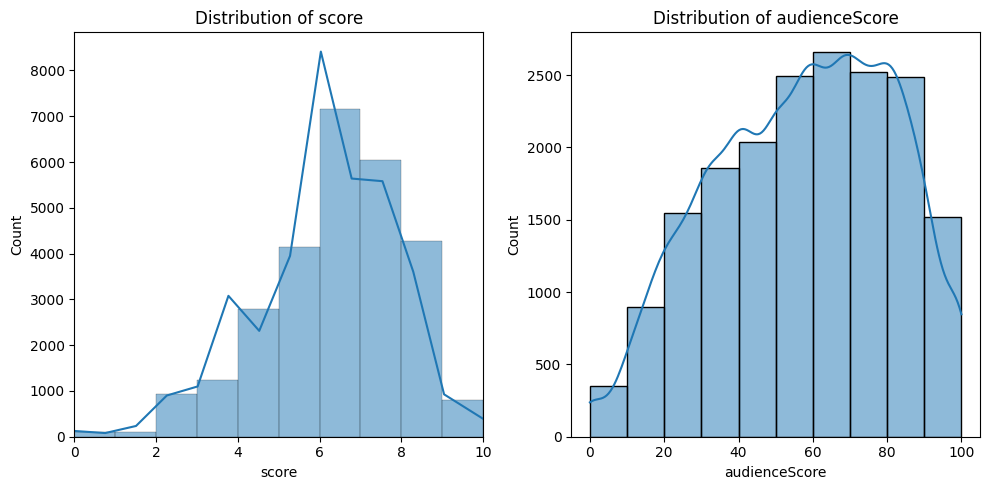

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(merged_df['score'].dropna(), bins=np.arange(0, 11, 1), kde=True)
plt.xlim(0, 10)
plt.title('Distribution of score')
plt.xlabel('score')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(merged_df['audienceScore'].dropna(), bins=10, kde=True)
plt.title('Distribution of audienceScore')

plt.tight_layout()
plt.show()

> Top 10 genre in the across the movie

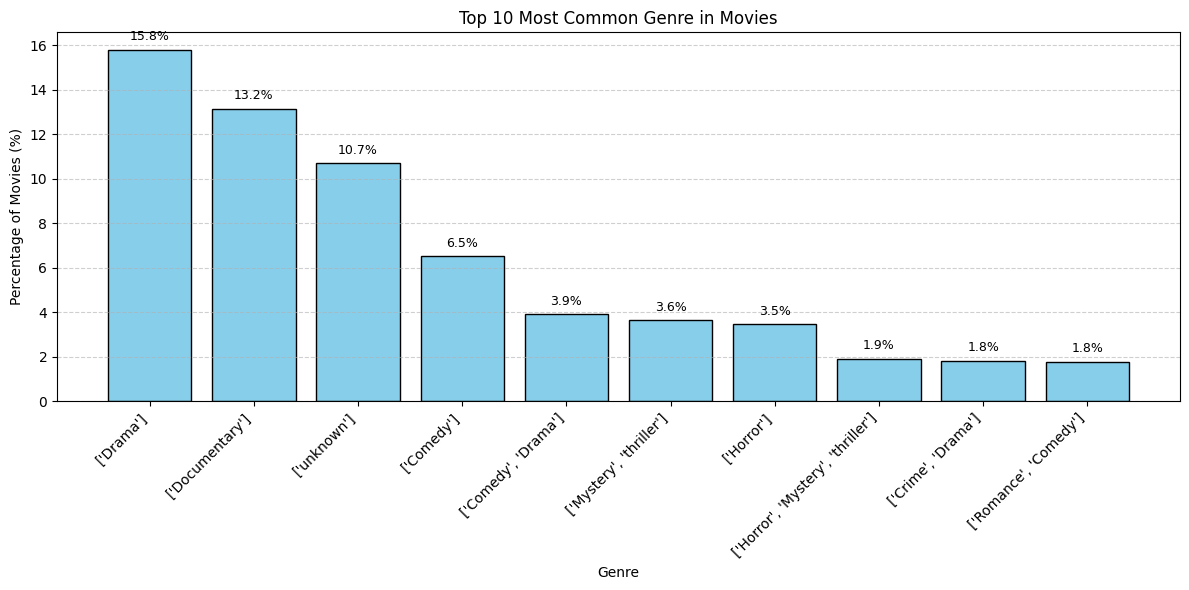

In [183]:
import matplotlib.pyplot as plt

# Count full genre list combinations as strings
genre_counts = merged_df['genre_list'].dropna().astype(str).value_counts(normalize=True) * 100

# Get top 10
top_10 = genre_counts.head(10)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10.index, top_10.values, color='skyblue', edgecolor='black')

# Formatting
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Movies (%)')
plt.xlabel('Genre')
plt.title('Top 10 Most Common Genre in Movies')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show percentage on top of bars (optional)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.show()


> **Merged dataset has 16% of movie of genre Drama followed by documentary with 13%

- treated null values as unknown

In [168]:

merged_df['genre_list'].str.contains('unknown').sum()

np.int64(2961)

In [185]:
merged_df['audienceScore'].mean()

np.float64(57.342096668843894)

In [ ]:
merged_df.rename(columns={'score': 'critic_score'}, inplace=True)
merged_df.rename(columns={'New_audienceScore': 'audience_score'}, inplace=True)

In [232]:
merged_df = merged_df.drop(columns=['audienceScore'])
merged_df.isna().sum()

title             0
genre_list        0
director_list     0
writer_list       0
language          0
TopCritic         0
sentiment         0
cleaned_text      0
critic_score      0
audience_score    0
dtype: int64

In [244]:
merged_df.columns

Index(['title', 'genre_list', 'director_list', 'writer_list', 'language',
       'TopCritic', 'sentiment', 'cleaned_text', 'critic_score',
       'audience_score'],
      dtype='object')

In [3]:
merged_df.to_csv('data\Final.csv', index=True)

NameError: name 'merged_df' is not defined

In [4]:
merged_df = pd.read_csv('data\Final.csv')

> weighted combined features

In [284]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000) # Tune parameters
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['combined_features_weighted'])

print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}") # (n_movies, n_features)

Shape of TF-IDF matrix: (27679, 5000)


In [ ]:
# Create a mapping from movie title to DataFrame index
indices = pd.Series(merged_df.index, index=merged_df['title']).drop_duplicates()

print("\nSample of title-to-index mapping:")
print(indices.head())


Sample of title-to-index mapping:
title
Love, Lies                  0
The Garden Murder Case      1
Angry Rice Wives            2
iSteve                      3
Tripping with Nils Frahm    4
dtype: int64
